In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_345_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_32_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_233_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_200_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_161_0110.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_47_1100.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_235_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_277_1100.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_199_0011.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_231_1011.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/train

**Importing necessary library**

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

**Installing tensorflow**

In [5]:
!pip install tensorflow

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 14.8 MB 7.2 MB/s            
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77055 sha256=095edaf2b2692158ed21575e53e447ba79934ebda1edc243f5af57bd7e202d1b
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
 

**setting the image fixed size for training and intializing the batch size, channel and number of epochs**

In [7]:
Image_Size= 256
Batch_Size = 32
Channels=3
Epochs=50

**determining number of pics and classes**

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/real-and-fake-face-detection/real_and_fake_face/",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 2041 files belonging to 2 classes.


**present class name**

In [9]:
class_names = dataset.class_names
class_names

['training_fake', 'training_real']

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0]


**trying out for the first image**

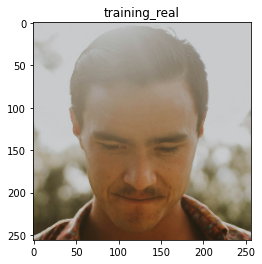

In [11]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

**creating function for splitting dataset**

In [12]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds=splitting_dataset_tf(dataset)

In [14]:
print(len(train_ds),len(val_ds),len(test_ds))

51 6 7


**Data Pipeline Optimization for Training, Validation, and Testing Datasets**

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Image Preprocessing for Resizing and Rescaling**

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Data augmentation**

In [17]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

**Building model architeture**

In [18]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
])

model.build(input_shape=input_shape)



**Model Compilation with Optimizer and Loss Function**

In [19]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Model Training with Training and Validation Data**

In [21]:
history = model.fit(
    train_ds,
    epochs=275,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/275
51/51 [==============================] - 3s 53ms/step - loss: 0.7245 - accuracy: 0.4945 - val_loss: 0.6984 - val_accuracy: 0.4963
Epoch 2/275
51/51 [==============================] - 2s 49ms/step - loss: 0.7052 - accuracy: 0.5086 - val_loss: 0.7022 - val_accuracy: 0.4939
Epoch 3/275
51/51 [==============================] - 3s 50ms/step - loss: 0.6971 - accuracy: 0.5147 - val_loss: 0.6899 - val_accuracy: 0.5300
Epoch 4/275
51/51 [==============================] - 2s 49ms/step - loss: 0.7007 - accuracy: 0.5086 - val_loss: 0.6946 - val_accuracy: 0.5116
Epoch 5/275
51/51 [==============================] - 2s 49ms/step - loss: 0.6975 - accuracy: 0.5214 - val_loss: 0.6884 - val_accuracy: 0.5325
Epoch 6/275
51/51 [==============================] - 2s 49ms/step - loss: 0.6955 - accuracy: 0.5116 - val_loss: 0.6862 - val_accuracy: 0.5735
Epoch 7/275
51/51 [==============================] - 2s 49ms/step - loss: 0.6938 - accuracy: 0.5263 - val_loss: 0.6908 - val_accuracy: 0.5263
Epoch 

**Checking accuracy of the model**

In [22]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 1s 14ms/step - loss: 0.2614 - accuracy: 0.8934


**Predicting Labels for a Batch of Images**

first image to predict
Actual label :  training_fake
Pred label :  training_fake


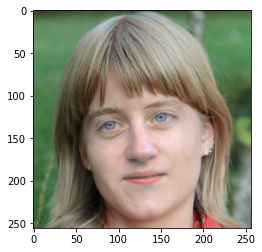

In [23]:
import numpy as np

for image_batch, label_batch in dataset.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label : ",class_names[first_label])
    
    
    batch_pred = model.predict(image_batch)
    print("Pred label : ",class_names[np.argmax(batch_pred[0])])

**Image Prediction Function Using the Model**

In [24]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Displaying Sample Predictions with Confidence**

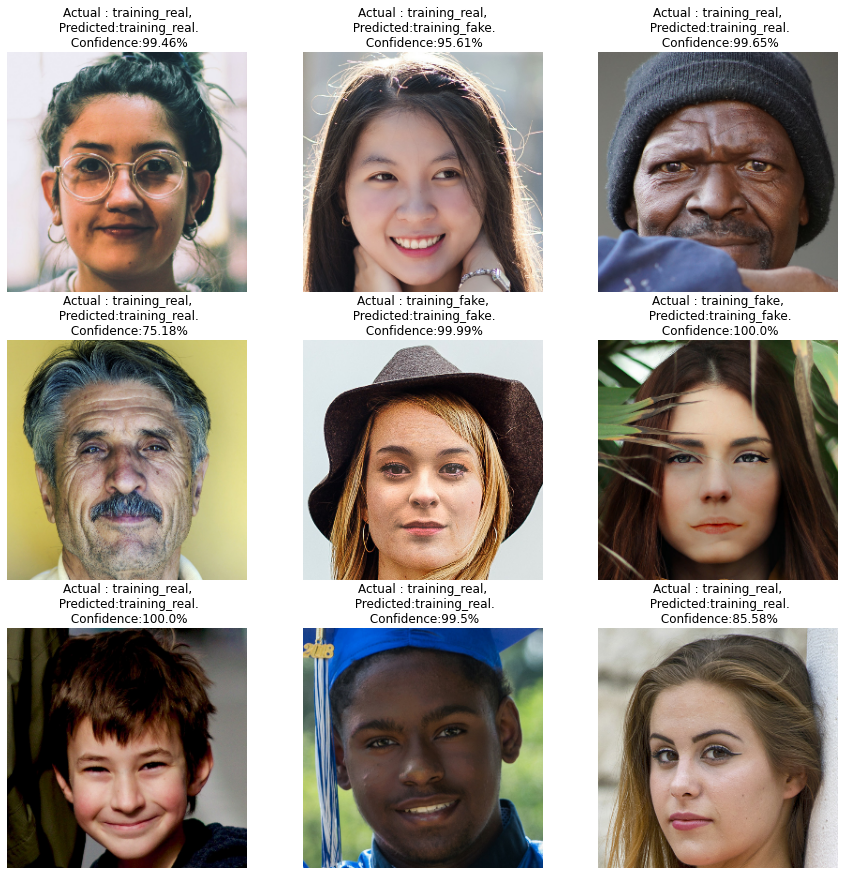

In [25]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        
        plt.axis("off")